In [1]:
!pip install opencv-python



In [2]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate 
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

In [3]:
#datasets 
train_data = 'C:/Users/pawan/Downloads/FCN/training/image_2'
train_gt = 'C:/Users/pawan/Downloads/FCN/trainin/gt_image_2'
test_data = 'C:/Users/pawan/Downloads/FCN/testing'

In [4]:
train_size = int(len(os.listdir(train_data)) * 0.8)
print(f"Number of Training Examples: {train_size}")

validate_size = int(len(os.listdir(train_data)) * 0.1)
print(f"Number of Validation Examples: {validate_size}")

test_size = int(len(os.listdir(train_data)) - train_size - validate_size)
print(f"Number of Testing Examples: {test_size}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [5]:
#initialization
img_size = 128
n_channels = 3
n_classes = 1
SEED = 123

In [6]:
#load image and return dir
def P_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    #addressing temp placeholders for images
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    
    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])
    #convert mask to bin mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [7]:
# Generate dataset variables
train_data = "C:/Users/pawan/Downloads/FCN/training/image_2/"
all_dataset = tf.data.Dataset.list_files(train_data + "*.png", seed=SEED)
all_dataset = all_dataset.map(P_image)
train_dataset = all_dataset.take(train_size + validate_size)
val_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)
test_dataset = all_dataset.skip(train_size + validate_size)

In [8]:
# applying transformations
# rescaling images to [0,1]
@tf .function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    intput_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask
@tf .function
#tensorflow f(x) apply pre-processing transformation 
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (img_size,img_size))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (img_size,img_size))
    	
    if tf.random.uniform(()) > 0.5:
            input_image = tf.image.flip_left_right(input_image)
            input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
	
    return input_image, input_mask
# preprocess validation 
@tf.function 
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (img_size, img_size))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (img_size, img_size))
    input_image, input_mask = normalize (input_image, input_mask)
    return input_image, input_mask

In [9]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
dataset = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
#train dataset 
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size = BUFFER_SIZE, seed = SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size = tf.data.AUTOTUNE)
#validation 
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size = tf.data.AUTOTUNE)
#testing 
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size = tf.data.AUTOTUNE)
print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


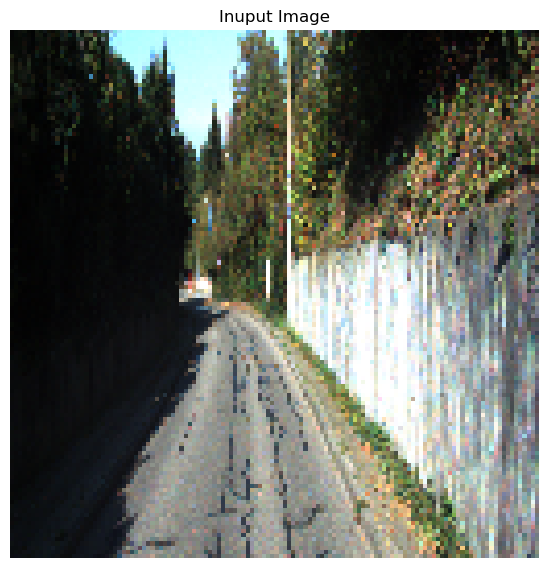

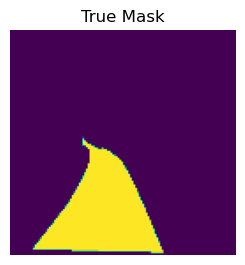

In [10]:
#function to view the images from the dir
def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Inuput Image', 'True Mask','Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

        plt.show()
    
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    
display_sample([sample_image[0], sample_mask[0]])

In [11]:
# get VGG-16 network as backbone 
vgg16_model = VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
#input shape 
input_shape = (img_size, img_size, n_channels)

In [13]:
#generate a new model using the VGG network
inputs = Input(input_shape)
#Vgg
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

#encoders
c1 = vgg16_model.get_layer('block3_pool').output
c2 = vgg16_model.get_layer('block4_pool').output
c3 = vgg16_model.get_layer('block5_pool').output

#decoders
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

#output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(n_classes, 1, activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = 'VGG_FCN8')

In [14]:
#loss function
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
             loss = BinaryCrossentropy(),
             metrics = [m_iou])

1/1 [==============================] - 8s 8s/step


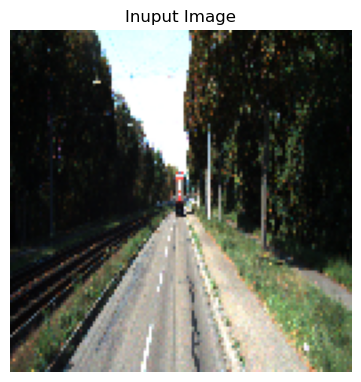

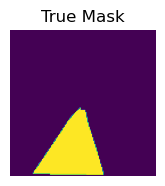

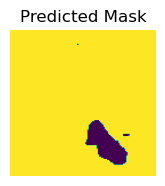

In [15]:
#check model
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.math.round(pred_mask)
    pred_mask = tf.expand_dims(pred_mask, axis = -1)
    return pred_mask

#show predcitions
def show_pred(dataset = None, num = 1):
    
    if dataset: #sample images 
        for image, mask in dataset['train'].take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
            
	
    else:#sample images 
        inf = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0], inf[0]])
        
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask 
    
show_pred()
        

In [16]:
#Train model callback logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_pred()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True)
]
# set vars 
Epochs = 200
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validate_size // BATCH_SIZE



1/1 [==============================] - 6s 6s/step


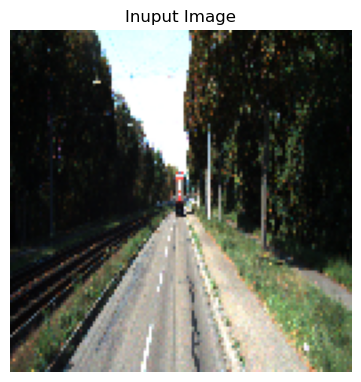

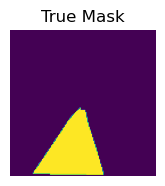

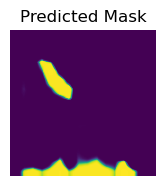


Sample Prediction after epoch 2



In [ ]:
model_history = model.fit(dataset['train'], epochs = Epochs, steps_per_epoch = steps_per_epoch,validation_steps = validation_steps, callbacks = callbacks  )

In [ ]:
#testing 
#calculate mask over image 
def weighted_img(img, initial_img, α = 1, ß = 0.5, Γ = 0):
    return cv2.addWeighted(initial_img, α, img, ß,  Γ)

#process individual image and it's mask
def process_image_mask(image, mask):
    mask = tf.math.round(mask)
    
    #convert to mask image
    zero_img = n.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)
    #convert to image 
    image = np.asarray(image, np.float32)
    #get the final image 
    final_img = weighted_img(mask, image)
    return final_img

In [ ]:
#save predictions 
def save_pred(dataset):
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f'Processing image : {index}')
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1
#save images as plot 
def save_samople(display_list, index):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imashow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.savefig(f'outputs/{index}.png')
        plt.show()

In [ ]:
os.mkdir('outputs')
save_predictions(dataset['test'])

In [ ]:
#functions for vedio 
def play(filename):
    html = ''
    vedio = open(filename, 'rb').read()
    src = 'C:/Users/pawan/OneDrive/Desktop/FCN/testing' + b64encode(video).decode()
    html += '<video width = 1000 controls autoplay loop><source src = "%s" type = "video/mp4"></video>' % src
    return html

In [ ]:
# to process individual image
def process_image(image):
    image = cv2.resize(image, (img_size, img_size))
    #bin mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])
    #convert mask to image 
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.dstack(mask, np.unit8)
    #get the final image 
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))
    
    return final_image 

In [ ]:
os.mkdir('videos')

In [ ]:
#project video
prj_video = 'project_video.mp4'
original_video = cv2.VideoCapture(test_data + prj_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))
#code def and create video writer
fourcc = cv2.VideoWriter('videos/' + prj_video, fourcc, fps(frame_width, frame_height))

#video process
while(original_video.isOpened()):
    ret, frame = original_video.read()
    
    if ret == True:#writing frame to file 'output.avi'
        output.write(process_image(frame))
        
	else:
        break
        
original_video.release()
output.release()

In [ ]:
play('videos/' + project_video)